# HTML table to Pandas Data Frame to Portal Item

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-HTML-table-to-Pandas-Data-Frame" data-toc-modified-id="Read-HTML-table-to-Pandas-Data-Frame-1">Read HTML table to Pandas Data Frame</a></span></li><li><span><a href="#Plot-as-a-map" data-toc-modified-id="Plot-as-a-map-2">Plot as a map</a></span></li><li><span><a href="#Publish-as-Portal-Item" data-toc-modified-id="Publish-as-Portal-Item-3">Publish as Portal Item</a></span></li></ul></div>

## Read HTML table to Pandas Data Frame

Often we read informative articles that present data in a tabular form. If such data contains location information, it would be much more insightful if presented as a cartographic map. Thus this sample shows how Pandas can be used to extract data from a table within a web page (in this case, a Wikipedia article) and how it can be then brought into the GIS for further analysis and visualization.

> **Note**: to run this sample, you need a few extra libraries in your conda environment. If you don't have the libraries, install them by running the following commands from cmd.exe or your shell
> ```python
> conda install lxml
> conda install html5lib
> conda install beautifulsoup4
>conda install matplotlib
>```

In [2]:
import pandas as pd

from arcgis.gis import GIS

Let us read the Wikipedia article on [Estimated number of guns per capita by country](https://en.wikipedia.org/wiki/Number_of_guns_per_capita_by_country) as a pandas data frame object

In [3]:
df = pd.read_html("https://en.wikipedia.org/wiki/Number_of_guns_per_capita_by_country")[0]

In [6]:
df.shape

(230, 10)

Let us process the table by dropping an unnecessary column.

In [7]:
df.head()

,Location,Firearms per 100,Region,Subregion,Population 2017,Civilian firearms,Computation method,Registered firearms,Unregistered firearms,Notes
0,United States,120.5,Americas,North America,326474000,393347000,1,1073743.0,"392,273,257 Est.",[note 2]
1,Falkland Islands,62.1,Americas,South America,3000,2000,2,1705.0,295,NaN
2,Yemen,52.8,Asia,Western Asia,28120000,14859000,2,NaN,NaN,NaN
3,New Caledonia,42.5,Oceania,Melanesia,270000,115000,2,55000.0,60000,NaN
4,Serbia,39.1,Europe,Southern Europe,6946000,2719000,2,1186086.0,1532914,NaN


In [8]:
del df['Notes']

In [9]:
df.head()

,Location,Firearms per 100,Region,Subregion,Population 2017,Civilian firearms,Computation method,Registered firearms,Unregistered firearms
0,United States,120.5,Americas,North America,326474000,393347000,1,1073743.0,"392,273,257 Est."
1,Falkland Islands,62.1,Americas,South America,3000,2000,2,1705.0,295
2,Yemen,52.8,Asia,Western Asia,28120000,14859000,2,NaN,NaN
3,New Caledonia,42.5,Oceania,Melanesia,270000,115000,2,55000.0,60000
4,Serbia,39.1,Europe,Southern Europe,6946000,2719000,2,1186086.0,1532914


Let's process column names so there are no spaces because this can cause inconsistencies with some GIS operations:

In [33]:
df.columns = df.columns.str.replace(" ", "_")

In [34]:
df.head()

,Location,Firearms_per_100,Region,Subregion,Population_2017,Civilian_firearms,Computation_method,Registered_firearms,Unregistered_firearms
0,United States,120.5,Americas,North America,326474000,393347000,1,1073743.0,"392,273,257 Est."
1,Falkland Islands,62.1,Americas,South America,3000,2000,2,1705.0,295
2,Yemen,52.8,Asia,Western Asia,28120000,14859000,2,NaN,NaN
3,New Caledonia,42.5,Oceania,Melanesia,270000,115000,2,55000.0,60000
4,Serbia,39.1,Europe,Southern Europe,6946000,2719000,2,1186086.0,1532914


In [10]:
gis = GIS(profile="your_online_admin_profile")

In [11]:
dpath = r"/Users/user_name/Job/"

df.to_csv(path_or_buf=dpath + "worldwide_gun_ownwership_df.csv", index=False)

## Plot as a map
Let us connect to our GIS to geocode this data and present it as a map, either by specifying username and password, for example  in `gis = GIS("https://www.arcgis.com", "your_org_username", "your_password")` or via an existing profile:

In [12]:
from arcgis.gis import GIS
import json

#gis = GIS("home")
gis = GIS(profile="your_online_admin_profile")

The table is using the `Location` column to signify the country name, so we'll create a feature collection by passing the mapping relationship below to the Geocoder through the `import_data()` method:

In [13]:
df.columns

Index(['Location', 'Firearms per 100', 'Region', 'Subregion',
       'Population 2017', 'Civilian firearms', 'Computation method',
       'Registered firearms', 'Unregistered firearms'],
      dtype='object')

In [14]:
fc = gis.content.import_data(df, {"CountryCode":"Location"})

In [15]:
gun_fset = fc.query()

In [16]:
map1 = gis.map(
    location = 'Brazil'
)


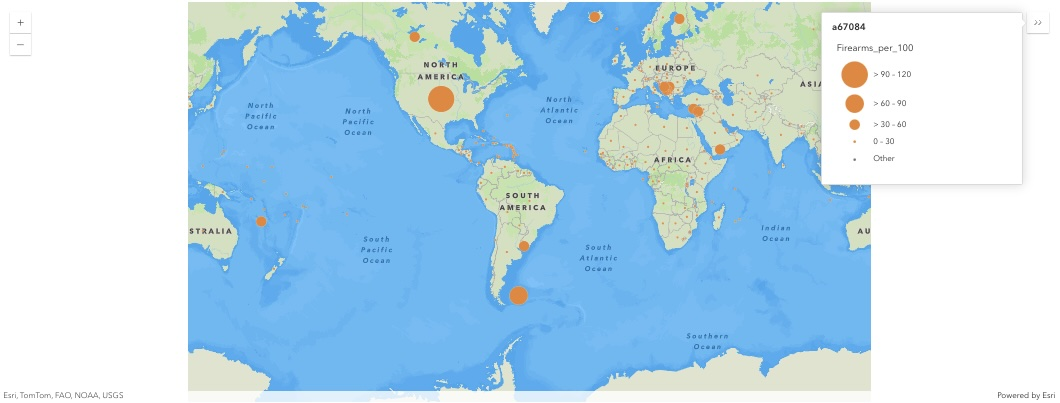

In [78]:
map1

In [18]:
map1.zoom = 1

We'll use smart mapping to render the points with varying sizes representing the number of firearms per 100 residents

In [19]:
map1.content.add(gun_fset)

In [20]:
smart_map_mgr = map1.content.renderer(0).smart_mapping()
smart_map_mgr.class_breaks_renderer(
    break_type="size",
    field="Firearms_per_100",
    num_classes=4
)

In [21]:
map1.legend.enabled=True

## Publish as Portal Item

Let us publish this layer as a **feature collection** item in our GIS

Let's use the `FolderManager` to get the logged in user's *Root* folder and add the Feature Collection to the folder.

In [22]:
fmgr = gis.content.folders

In [23]:
root = fmgr.get(owner=gis.users.me)

In [24]:
from arcgis.gis import ItemProperties, ItemTypeEnum

In [26]:
iprops = ItemProperties(title="Worldwide Firearms Ownership Folder stream",
                        item_type=ItemTypeEnum.FEATURE_COLLECTION,
                        tags=["guns,violence"],
                        snippet = "GSR Worldwide firearms ownership",
                        description = "test description",
                        type_keywords = ["Data", "Feature Collection", "Singlelayer"],
                        extent = "-102.5272,-41.7886,172.5967,64.984")

In [27]:
rf_item = root.add(item_properties=iprops,
                   text = json.dumps({"layers": [dict(fc.properties)]}))

In [69]:
rf_item.result()

<Item title:"Worldwide Firearms Ownership Folder stream" type:Feature Collection owner:ArcGISPyAPIBot>